In [1]:
import os
import re
import numpy as np
import pandas as pd
import tifffile
from tqdm import tqdm

# =============================================================================
# Helper Function: Extract Group, Sample, and Repeat Information
# =============================================================================
def extract_info_from_filename(filename):
    """
    Extracts group (Act/Rep), sample, and repeat information from the filename.
    It first removes any time suffix (e.g., _t0) if present.
    
    Expected filename formats include:
      - 'Act_01_002.nd2' or 'Act_01_002.tiff'
      - 'Rep_A1_001.nd2' or 'Rep_A1_001.tiff'
      
    Returns:
      A tuple: (Group, Sample, Repeat), or ('Unknown', 'Unknown', 'Unknown') if not matched.
    """
    base = re.sub(r'_t\d+', '', os.path.splitext(filename)[0])
    pattern = re.compile(r'^(Act|Rep)_([A-Za-z0-9]+)_(\d{3})', re.IGNORECASE)
    m = pattern.search(base)
    if m:
        return m.group(1), m.group(2), m.group(3)
    else:
        return 'Unknown', 'Unknown', 'Unknown'

# =============================================================================
# Runnable Step 3: Intensity Calculation and Excel Output with Background Correction
# =============================================================================
def create_excel_from_tiff_and_mask(dsred_tiff_dir, gfp_tiff_dir, mask_dir, output_excel):
    """
    Processes DsRed TIFF files (with corresponding GFP and mask files) to calculate cell-level intensities.
    For each cell (as determined by the DAPI mask), the average intensities in the GFP and DsRed channels are computed.
    
    In addition, the background intensity (calculated from areas not covered by any mask) is computed
    for both channels and recorded as 'DsRed_background' and 'GFP_background'. Then, the net mean intensity
    for each cell is computed as the difference between the cell's mean intensity and the background.
    
    The file name is parsed to extract Group, Sample, and Repeat information.
    
    Parameters:
      dsred_tiff_dir (str): Directory containing DsRed TIFF images.
      gfp_tiff_dir (str): Directory containing GFP TIFF images (with matching filenames).
      mask_dir (str): Directory containing the DAPI-generated mask TIFFs (named as <base>_mask.tiff).
      output_excel (str): Path to the output Excel file.
    """
    # List DsRed TIFF files (exclude any mask files)
    dsred_files = [f for f in os.listdir(dsred_tiff_dir)
                   if f.lower().endswith(('.tiff', '.tif')) and '_mask' not in f]
    
    if not dsred_files:
        print("No DsRed TIFF files found in", dsred_tiff_dir)
        return
    
    data = []
    
    # Process each DsRed TIFF file
    for tiff_file in tqdm(dsred_files, desc="Processing TIFF files"):
        # Construct full paths for DsRed, GFP, and mask files
        dsred_path = os.path.join(dsred_tiff_dir, tiff_file)
        gfp_path   = os.path.join(gfp_tiff_dir, tiff_file)
        mask_filename = os.path.splitext(tiff_file)[0] + "_mask.tiff"
        mask_path  = os.path.join(mask_dir, mask_filename)
        
        # Check that corresponding GFP and mask files exist
        if not os.path.exists(gfp_path):
            print(f"GFP file not found for {tiff_file}, skipping.")
            continue
        if not os.path.exists(mask_path):
            print(f"Mask file not found for {tiff_file}, skipping.")
            continue
        
        # Read images
        try:
            dsred_img = tifffile.imread(dsred_path)
            gfp_img   = tifffile.imread(gfp_path)
            mask_img  = tifffile.imread(mask_path)
        except Exception as e:
            print(f"Error reading files for {tiff_file}: {e}")
            continue
        
        # Compute background intensities from areas outside any cell (mask == 0)
        background_mask = (mask_img == 0)
        if np.any(background_mask):
            dsred_background = np.mean(dsred_img[background_mask])
            gfp_background   = np.mean(gfp_img[background_mask])
        else:
            dsred_background = np.nan
            gfp_background   = np.nan
        
        # Identify unique cell labels (ignore background, assumed to be 0)
        cell_indices = np.unique(mask_img)
        cell_indices = cell_indices[cell_indices != 0]
        
        # Compute average intensities for each cell, record background, and calculate net mean values
        for cell in cell_indices:
            cell_mask = (mask_img == cell)
            avg_gfp   = np.mean(gfp_img[cell_mask])
            avg_dsred = np.mean(dsred_img[cell_mask])
            
            # Compute net mean as the difference between cell's mean intensity and background intensity
            gfp_net_mean   = avg_gfp - gfp_background if not np.isnan(gfp_background) else np.nan
            dsred_net_mean = avg_dsred - dsred_background if not np.isnan(dsred_background) else np.nan
            
            record = {
                "File Name": tiff_file,
                "Mask Index": cell,
                "Average GFP Intensity": avg_gfp,
                "Average DsRed Intensity": avg_dsred,
                "GFP_background": gfp_background,
                "DsRed_background": dsred_background,
                "GFP_net_mean": gfp_net_mean,
                "DsRed_net_mean": dsred_net_mean
            }
            data.append(record)
    
    # Create DataFrame from collected data
    df = pd.DataFrame(data)
    
    # Extract metadata (Group, Sample, Repeat) from the file name
    df[['Group', 'Sample', 'Repeat']] = df['File Name'].apply(lambda x: pd.Series(extract_info_from_filename(x)))
    
    # Drop the original file name column
    df = df.drop(columns=["File Name"])
    
    # Rename intensity columns for clarity
    df = df.rename(columns={
        "Average GFP Intensity": "GFP_Mean",
        "Average DsRed Intensity": "DsRed_Mean"
    })
    
    # Arrange columns in desired order
    df = df[['Group', 'Sample', 'Repeat', 'Mask Index', 
             "GFP_Mean", "DsRed_Mean", "GFP_background", "DsRed_background", 
             "GFP_net_mean", "DsRed_net_mean"]]
    
    # Write DataFrame to an Excel file
    df.to_excel(output_excel, index=False)
    print("Excel summary saved to:", output_excel)

# ----- Example Usage -----
# Adjust these paths as needed for your data.
dsred_tiff_dir = r"A:\_Ongoing\20250215_ActRep\Output\DsRed_TIFF"
gfp_tiff_dir   = r"A:\_Ongoing\20250215_ActRep\Output\GFP_TIFF"
mask_dir       = r"A:\_Ongoing\20250215_ActRep\Output\mask"
output_excel   = r"A:\_Ongoing\20250215_ActRep\Output\summary.xlsx"

create_excel_from_tiff_and_mask(dsred_tiff_dir, gfp_tiff_dir, mask_dir, output_excel)

Processing TIFF files: 100%|██████████| 2400/2400 [01:01<00:00, 39.13it/s]


Excel summary saved to: A:\_Ongoing\20250215_ActRep\Output\summary.xlsx


In [2]:
import os
import pandas as pd

# -----------------------------
# PARAMETERS & FILE PATHS
# -----------------------------
# Input Excel file from the previous analysis step (summary of intensities)
input_excel = r"A:\_Ongoing\20250215_ActRep\Output\summary.xlsx"

# Output Excel file with the updated sample names (reporter expression with renamed samples)
output_excel_renamed = r"A:\_Ongoing\20250215_ActRep\Output\summary_renamed.xlsx"

# -----------------------------
# SAMPLE MAPPING DICTIONARY
# -----------------------------
# Modify this dictionary for different sample organizations in the future.
sample_mapping = {
    "A1": "Tile 1",
    "A2": "Tile 2",
    "A3": "Tile 3",
    "A4": "Tile 4",
    "A5": "Tile 5",
    "A6": "Tile 6",
    "B1": "Tile 7",
    "B2": "Tile 8",
    "B3": "Tile 9",
    "B4": "Tile 10",
    "B5": "Tile 11",
    "B6": "Tile 12",
    "C1": "Tile 13",
    "C2": "Tile 14",
    "C3": "LAP*IDR",
    "C4": "LAPIDR",
    "C5": "LIPIDR",
    "C6": "FL",
    "D1": "optLAP*IDR",
    "D2": "Halo_NLS",
    "D3": "AR_RUNX2",
    "D4": "Tile1woNLS",
    "D5": "RUNX2CTD",
    "D6": "VP16"
}

# -----------------------------
# READ INPUT DATA
# -----------------------------
df = pd.read_excel(input_excel)

# -----------------------------
# APPLY SAMPLE MAPPING
# -----------------------------
# Create a new column "Sample_name" by mapping the "Sample" column
# If a sample code is not found in the dictionary, its name will be NaN.
df["Sample_name"] = df["Sample"].map(sample_mapping)

# -----------------------------
# SAVE THE UPDATED DATAFRAME
# -----------------------------
# Rearranging columns if desired (e.g., putting "Sample_name" next to "Sample")
# Here, we assume the DataFrame already has columns such as:
# Group, Sample, Repeat, Mask Index, GFP_Mean, DsRed_Mean, GFP_background, DsRed_background, GFP_net_mean, DsRed_net_mean
# We'll simply place "Sample_name" after "Sample" for clarity.
cols = df.columns.tolist()
if "Sample" in cols and "Sample_name" in cols:
    # Remove the sample name column and reinsert it after "Sample"
    cols.remove("Sample_name")
    sample_index = cols.index("Sample") + 1
    cols.insert(sample_index, "Sample_name")
    df = df[cols]

# Write the updated DataFrame to a new Excel file
df.to_excel(output_excel_renamed, index=False)
print("Renamed summary Excel file saved to:", output_excel_renamed)


Renamed summary Excel file saved to: A:\_Ongoing\20250215_ActRep\Output\summary_renamed.xlsx


In [3]:
import os
import pandas as pd

# -----------------------------
# PARAMETERS & FILE PATHS
# -----------------------------
# Input Excel file from the previous renaming step (contains "Sample" and "Sample_name")
input_excel = r"A:\_Ongoing\20250215_ActRep\Output\summary_renamed.xlsx"

# Output Excel file for filtered data
output_excel_filtered = r"A:\_Ongoing\20250215_ActRep\Output\summary_filtered_renamed.xlsx"

# Define the cutoff value for DsRed_net_mean.
# Any cell with a DsRed_net_mean below this value will be removed.
cutoff_value = 10  # Adjust this value as needed

# -----------------------------
# READ INPUT DATA
# -----------------------------
df = pd.read_excel(input_excel)

# -----------------------------
# FILTER DATA
# -----------------------------
# Filter out rows where DsRed_net_mean is less than the cutoff value.
df_filtered = df[df["DsRed_net_mean"] >= cutoff_value].copy()

# Save the filtered DataFrame to an Excel file.
df_filtered.to_excel(output_excel_filtered, index=False)
print("Filtered summary Excel file saved to:", output_excel_filtered)

# -----------------------------
# COUNT AND PRINT DATA POINTS PER SAMPLE, SEPARATED BY GROUP
# -----------------------------
# Define the desired order of sample codes from A1 to D6.
sample_order = [
    "A1", "A2", "A3", "A4", "A5", "A6",
    "B1", "B2", "B3", "B4", "B5", "B6",
    "C1", "C2", "C3", "C4", "C5", "C6",
    "D1", "D2", "D3", "D4", "D5", "D6"
]

# Get unique groups (e.g. Act and Rep) from the data
groups = sorted(df["Group"].dropna().unique())

print("\nSummary of filtering by DsRed_net_mean cutoff (separated by group):")
for group in groups:
    print(f"\nGroup: {group}")
    for code in sample_order:
        # Filter by group and sample code
        subset = df[(df["Group"] == group) & (df["Sample"] == code)]
        total = subset.shape[0]
        passed = df_filtered[(df_filtered["Group"] == group) & (df_filtered["Sample"] == code)].shape[0]
        failed = total - passed
        # Retrieve descriptive sample name (if available)
        sample_name_arr = df.loc[(df["Group"] == group) & (df["Sample"] == code), "Sample_name"].unique()
        sample_name = sample_name_arr[0] if len(sample_name_arr) > 0 else "Unknown"
        print(f"  Sample {code} ({sample_name}): Total = {total}, Passed = {passed}, Failed = {failed}")


Filtered summary Excel file saved to: A:\_Ongoing\20250215_ActRep\Output\summary_filtered_renamed.xlsx

Summary of filtering by DsRed_net_mean cutoff (separated by group):

Group: Rep
  Sample A1 (Tile 1): Total = 2242, Passed = 2141, Failed = 101
  Sample A2 (Tile 2): Total = 6213, Passed = 5836, Failed = 377
  Sample A3 (Tile 3): Total = 3985, Passed = 3266, Failed = 719
  Sample A4 (Tile 4): Total = 8860, Passed = 8755, Failed = 105
  Sample A5 (Tile 5): Total = 3797, Passed = 3612, Failed = 185
  Sample A6 (Tile 6): Total = 4513, Passed = 4123, Failed = 390
  Sample B1 (Tile 7): Total = 1723, Passed = 1192, Failed = 531
  Sample B2 (Tile 8): Total = 6145, Passed = 5777, Failed = 368
  Sample B3 (Tile 9): Total = 5487, Passed = 4066, Failed = 1421
  Sample B4 (Tile 10): Total = 6082, Passed = 5595, Failed = 487
  Sample B5 (Tile 11): Total = 3270, Passed = 2850, Failed = 420
  Sample B6 (Tile 12): Total = 278, Passed = 88, Failed = 190
  Sample C1 (Tile 13): Total = 1392, Passed = 1

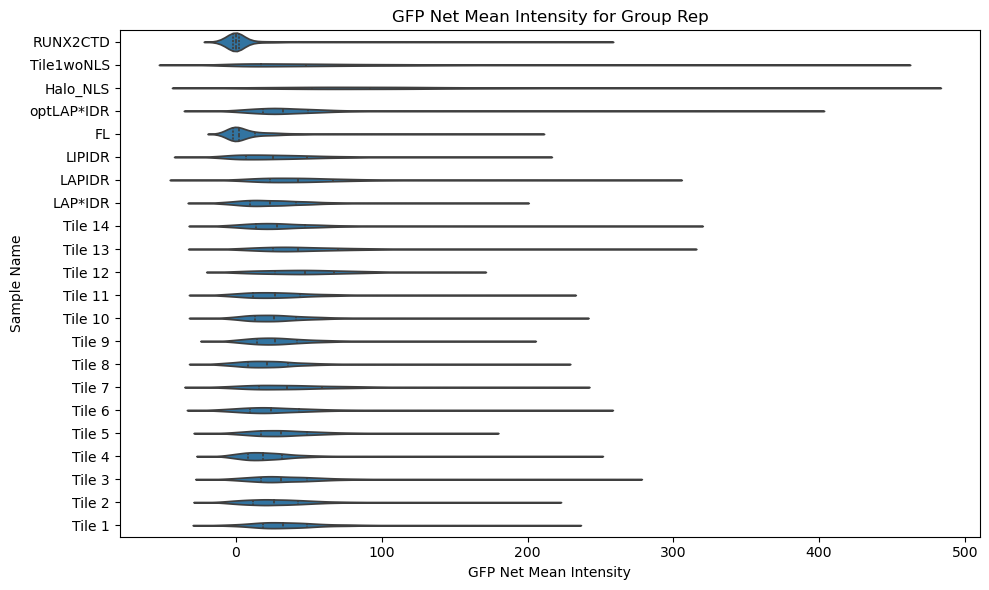

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# PARAMETERS & FILE PATHS
# -----------------------------
# Input Excel file from the previous filtering and renaming step
input_excel = r"A:\_Ongoing\20250215_ActRep\Output\summary_filtered_renamed.xlsx"

# Define the desired order of sample codes from A1 to D6
sample_order = [
    "A1", "A2", "A3", "A4", "A5", "A6",
    "B1", "B2", "B3", "B4", "B5", "B6",
    "C1", "C2", "C3", "C4", "C5", "C6",
    "D1", "D2", "D3", "D4", "D5", "D6"
]

# Create a dictionary mapping each sample code to its order index for sorting purposes.
order_dict = {code: i for i, code in enumerate(sample_order)}

# -----------------------------
# READ DATA
# -----------------------------
df = pd.read_excel(input_excel)

# -----------------------------
# PLOTTING FUNCTION
# -----------------------------
def plot_violin_for_group(df_group, group_name):
    """
    Create a horizontal violin plot for a given group.
    The y-axis displays descriptive sample names in reversed order (lowest sample code at the top),
    and the x-axis displays the GFP net mean intensity.
    """
    # Get unique sample codes present in this group and sort them by our defined order.
    unique_codes = df_group["Sample"].unique().tolist()
    unique_codes_sorted = sorted(unique_codes, key=lambda x: order_dict.get(x, 999))
    # Reverse the order so that the lowest sample code appears at the top.
    unique_codes_sorted_reversed = list(reversed(unique_codes_sorted))
    
    # Now, derive the corresponding descriptive sample names in that reversed order.
    order_sample_names = []
    for code in unique_codes_sorted_reversed:
        # Assuming all rows for a given code have the same Sample_name:
        sample_name = df_group.loc[df_group["Sample"] == code, "Sample_name"].iloc[0]
        order_sample_names.append(sample_name)
    
    # Create the horizontal violin plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=df_group,
        x="GFP_net_mean",
        y="Sample_name",
        order=order_sample_names,
        orient="h",
        inner="quartile"  # optionally show quartiles
    )
    plt.title(f"GFP Net Mean Intensity for Group {group_name}")
    plt.xlabel("GFP Net Mean Intensity")
    plt.ylabel("Sample Name")
    plt.tight_layout()
    plt.show()

# -----------------------------
# SEPARATE DATA BY GROUP AND PLOT
# -----------------------------
groups = df["Group"].dropna().unique()

for group in groups:
    df_group = df[df["Group"] == group].copy()
    plot_violin_for_group(df_group, group)
